In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Deep Graph Embeddings 

This is a notebook which walks through 2 of the most popular deep learning based graph embeddings - SDNE and LINE. These architectures are different from the previous notebooks owing to the fact that these use first and second order proximity to determine the node representations. The first order proximity suggests that nodes can be related based on adjacency and the second order suggests that nodes are characterised based on the neighbourhood of the nodes.Both the papers associated with the embeddings are present here:

- [SDNE](https://paperswithcode.com/method/sdne)
- [LINE](https://paperswithcode.com/method/line)

These are very high order embeddings and used for capturing representations on exclusively large networks. These are scalable representations which are based on regressed adjacency properties and laplacian maps.

<img src="https://pbs.twimg.com/media/DPJSagrX0AAYdSy.jpg">

In [ ]:
!pip install networkx
!pip install gensim
!pip install torch
!pip install tensorflow

## SDNE (Structural Deep Network Embeddings)

<img src="https://www.programmersought.com/images/979/223a8a8bc9b82f9255018d248c355c8b.png">

### SDNE algorithm principle

#### Similarity definition

The definition of similarity in SDNE is the same as LINE. Simply put, the first-order similarity measures the similarity between two adjacent vertex pairs. The second-order similarity measures the similarity of the neighbor sets of two vertices.

#### 2nd order similarity optimization goal

``` L2nd​=∑i=1n​∣∣x^i​−xi​∣∣22​```

Here we use the adjacency matrix of the graph for input. For the i-th vertex, we have x_i=s_i xi​=si​,Every s_i si​Both contain the neighbor structure information of vertex i, so this reconstruction process can make vertices with similar structures have similar embedding representation vectors.

One problem here is that due to the sparseness of the graph, the number of non-zero elements in the adjacency matrix S is far fewer than zero elements, so for the neural network as long as all output 0 can achieve a good effect, this is not ours want.

One method given in the article is to use a weighted loss function, which has a higher penalty coefficient for non-zero elements.

1st order similarity optimization goal
Capture Reconstruction loss of the predicted and true values

2nd order similarity optimization goal
Use the trace of the laplacian matrix and normalize the results

The loss function can make the embedding vectors corresponding to two adjacent vertices in the graph close in the hidden space.


Where L is the Laplacian matrix corresponding to the graph, L = D-S L=D−S, D is the degree matrix of the vertices in the graph, and S is the adjacency matrix.


Overall optimization goal
The loss function of joint optimization is
```Lmix​=L2nd​+αL1st​+νLreg​```

L_{reg} Lreg​Is the regularization term, 
alpha αTo control the parameters of the first-order loss


The second order proximity is preserved by passing the adjacency matrix of te graph through an unsupervised autoencoder which has a built in reconstruction loss function it must minimize.

<img src="https://miro.medium.com/proxy/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png">

In [ ]:
train_df=pd.read_csv('../input/google-quest-challenge/train.csv')
train_df.head()

In [ ]:
import networkx as nx
import scipy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

train_df=pd.read_csv('../input/google-quest-challenge/train.csv')
print(train_df.columns)
g=nx.from_pandas_edgelist(train_df[:500],source='question_body',target='category')
nx.draw(g)
edgelist=[]
ed_c=g.number_of_edges()
for e in g.edges():
    node1=e[0]
    node2=e[1]
    n_c=0
    n_c+=len([j for j in g.neighbors(node1)])
    n_c+=len([j for j in g.neighbors(node2)])
    normalized_count=n_c/ed_c
    g[e[0]][e[1]]['weight']=normalized_count

nx.draw(g,pos=nx.spring_layout(g))

In [ ]:
import tensorflow as tf

class Loss():
    def reconstruction_loss(self,beta):
        self.beta=beta
        def cal(y_pred,y_true):
            delta=tf.square((y_pred-y_true)*self.beta)
            return tf.reduce_sum(delta)
        return cal
    def loss_laplace(self,alpha):
        self.alpha=alpha
        def cal(y_true, y_pred):
            L = y_true
            Y = y_pred
            batch_size = tf.cast(tf.keras.backend.shape(L)[0], tf.float32)
            return self.alpha * 2 * tf.linalg.trace(tf.matmul(tf.matmul(Y, L, transpose_a=True), Y)) / batch_size
        return cal

class SDNE():
    def __init__(self,graph,alpha,beta,hidden_dims):
        self.graph=graph
        self.alpha=alpha
        self.beta=beta
        self.hidden_dims=hidden_dims
        self.A=nx.adjacency_matrix(self.graph,nodelist=range(self.graph.number_of_nodes()))
        idx=np.arange(self.graph.number_of_nodes())
        degree_vals=np.array([(self.graph.degree[node]) for node in list(self.graph.nodes())])
        n=self.graph.number_of_nodes()
        #(data,row,columns)
        self.D=scipy.sparse.coo_matrix((degree_vals,(idx,idx)),shape=(n,n))
        #self.D=nx.from_scipy_sparse_matrix(D)
        
        L=self.D-self.A
        L=nx.from_scipy_sparse_matrix(L)
        self.L=nx.laplacian_matrix(L)
        self.inputs=[self.A,self.L]
        self.embeddings=[]
        self.node_size=self.graph.number_of_nodes()
        self.model()
        
    def create_model(self): 
        node_size=self.graph.number_of_nodes()
        A = tf.keras.layers.Input(shape=(node_size,))
        L = tf.keras.layers.Input(shape=(None,))
        encoder_module = A
        for i in range(len(self.hidden_dims)):
            if i == len(self.hidden_dims) - 1:
                encoder_module = tf.keras.layers.Dense(self.hidden_dims[i], activation='sigmoid', name='encoders')(encoder_module)
            else:
                encoder_module = tf.keras.layers.Dense(self.hidden_dims[i], activation='relu')(encoder_module)
        Y = encoder_module
        for i in reversed(range(len(self.hidden_dims) - 1)):
            decoder_module = tf.keras.layers.Dense(self.hidden_dims[i], activation='relu')(encoder_module)

        A_ = tf.keras.layers.Dense(node_size, 'relu', name='decoder')(decoder_module)
        self.models = tf.keras.Model(inputs=[A, L], outputs=[A_, Y])
        self.emb = tf.keras.Model(inputs=A, outputs=Y)
        return self.models, self.emb

    def model(self, opt='adam',epochs=10, initial_epoch=0, verbose=1):

        self.models, self.emb_model = self.create_model()
        loss=Loss()
        self.models.compile(opt, [loss.reconstruction_loss(self.beta), loss.loss_laplace(self.alpha)])
#         self.train(1,0,1)
        self.get_embeddings()
        batch_size = self.node_size
        print(self.models.summary())
        print(self.A.todense())
        return self.models.fit([self.A.todense(), self.L.todense()], [self.A.todense(), self.L.todense()],
                                  batch_size=batch_size, epochs=epochs, initial_epoch=initial_epoch, verbose=verbose)
    #def train(self,epochs=10, initial_epoch=0, verbose=1):
    def get_embeddings(self):
        
        embeddings = self.emb_model.predict(self.A.todense(), batch_size=self.node_size)
        for _,emb in enumerate(embeddings):
            self.embeddings.append(emb)
        return self.embeddings   
    
    def node_level_embedding(self,node,embed):
        embed_node=embed[node]
        vals=list(self.graph.nodes())
        def chebyshev_distance(node1,node2):
            return scipy.spatial.distance.chebyshev(node1,node2)
        distances=[]
        questions=[]
        for i in range(self.graph.number_of_nodes()):
            if i!=node:
                distances.append(chebyshev_distance(embed_node,embed[i]))
                questions.append(vals[i])
        return vals[node],distances,questions
g=nx.from_pandas_edgelist(train_df[:5000],source='question_body',target='category')
#nx.draw(g)

df=pd.DataFrame(columns=['Q1','Qn'])
df['Q1']=[train_df['question_body'][0]]*1000
list_ques=[]
for i in range(1001):
    if i!=0:
        list_ques.append(train_df['question_body'][i])
df['Qn']=list_ques
#g=nx.from_pandas_edgelist(df,source='Q1',target='Qn')
nx.draw(g)
hidden_dims=[32,16]
alpha=1e-4
beta=1e-5
sdne=SDNE(g,alpha,beta,hidden_dims)
sdne.model()
emb=sdne.get_embeddings()

node_num=339
node,distances,questions=sdne.node_level_embedding(node_num,emb)
sdne_df=pd.DataFrame(columns=['Question','Sample_Question','Chebyshev_Distance'])
sdne_df['Question']=[node]*len(distances)
sdne_df['Sample_Question']=questions
sdne_df['Chebyshev_Distance']=distances
sdne_df.head()

sdne_df.to_csv('../SDNE_Embeddings.csv',index=False)
#print(emb)

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)
sdne_g=nx.from_pandas_edgelist(sdne_df,source='Question',target='Sample_Question',edge_attr='Chebyshev_Distance')
G=sdne_g
def plotter(G,title):
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    for n, p in pos.items():
        G.nodes[n]['pos'] = p
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.5,color='#888'),
        hoverinfo='none',
        mode='lines')

    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])
    node_trace = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='RdBu',
            reversescale=True,
            color=[],
            size=15,
            colorbar=dict(
                thickness=10,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=0)))

    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
    for node, adjacencies in enumerate(G.adjacency()):
        node_trace['marker']['color']+=tuple([len(adjacencies[1])])
        node_info = adjacencies[0] +' # of connections: '+str(len(adjacencies[1]))
        node_trace['text']+=tuple([node_info])
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title=title,
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="No. of connections",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

    iplot(fig)
plotter(G,'SDNE Distance')

## LINE (Large Scale Information Network Embedding)


<img src="https://www.programmersought.com/images/996/f42357dccce22d2ee44665a2ece8e63c.png">

### first-order proximity
The first-order similarity is used to describe the local similarity between pairs of vertices in the graph, and the formal description is if u u, v vThere are straight edges between them, then the edges are right w_{uv} wuv​It is the similarity between two vertices. If there are no straight edges, the first-order similarity is 0.
As shown in the figure above, there is a straight edge between 6 and 7, and the edge weight is larger, it is considered that the two are similar and the first-order similarity is higher, but there is no between 5 and 6 If the edges are directly connected, the first-order similarity between the two is 0.

### second-order proximity
Is only 1st order similarity enough? Obviously not enough. As shown in the figure above, although there are no straight edges between 5 and 6, they have many similar neighbor vertices (1,2,3,4). This can actually indicate that 5 and 6 are similar, and 2 Order similarity is used to describe this relationship.
is formally defined as
Order p_u=(w_{u,1},...,w_{u,|V|}) pu​=(wu,1​,...,wu,∣V∣​)Represents vertices u u1st order similarity with all other vertices, then u uversus v vThe second-order similarity can be passed p_u pu​with p_v pv​The similarity is expressed. If u uversus v vIf there are no identical neighbor vertices, the second-order similarity is 0.

Implementation Details:

For creating Line embeddings, we  use the default SDNE script and convert the reconstruction loss (autoencoder loss for SDNE) to a KL divergence based loss.The goal of LINE is to minimize the difference between the input and embedding distributions. This is achieved using KL divergence:

<img src="https://miro.medium.com/max/875/0*O-MXQk5ztaOYsGQH">


 
LINE defines two joint probability distributions for each pair of nodes then minimizes the KL divergence of the distributions. The two distributions are the adjacency matrix and the dot product of node embedding. KL Divergence is an important similarity metric in information theory and entropy. The algorithm is used in probabilistic generative models like Variational Autoencoders, which embed inputs of an autoencoder into a latent space, which becomes the distribution.
Since the algorithm has to define new functions for each increasing order of proximity, LINE doesn’t perform very well if the application needs an understanding of node community structure.
Nevertheless, the simplicity and effectiveness of LINE are just a couple reasons why it was the most cited paper on WWW of 2015. This work helped inspire interest in Graph Learning as a niche in Machine Learning and eventually Deep Learning in specific.

<img src="https://miro.medium.com/max/625/0*UhcvOUeSRFGs8tp6.gif">

Resource:
- [blog](https://towardsdatascience.com/overview-of-deep-learning-on-graph-embeddings-4305c10ad4a4)


In [ ]:
import tensorflow as tf

class Loss():
    def kldivergence_loss(self,beta):
        self.beta=beta
        def cal(y_pred,y_true):
            delta=(y_true*self.beta)*((tf.square(y_pred-y_true))/(y_pred+1e-2))
            return tf.reduce_sum(delta)
#             return tf.keras.losses.KLDivergence(y_pred,y_true)
        return cal
class LINE():
    def __init__(self,graph,alpha,beta,hidden_dims):
        self.graph=graph
        self.alpha=alpha
        self.beta=beta
        self.hidden_dims=hidden_dims
        self.A=nx.adjacency_matrix(self.graph,nodelist=range(self.graph.number_of_nodes()))
        idx=np.arange(self.graph.number_of_nodes())
        degree_vals=np.array([(self.graph.degree[node]) for node in list(self.graph.nodes())])
        n=self.graph.number_of_nodes()
        #(data,row,columns)
        self.D=scipy.sparse.coo_matrix((degree_vals,(idx,idx)),shape=(n,n))
        #self.D=nx.from_scipy_sparse_matrix(D)
        
        L=self.D-self.A
        L=nx.from_scipy_sparse_matrix(L)
        self.L=nx.laplacian_matrix(L)
        self.inputs=[self.A,self.L]
        self.embeddings=[]
        self.node_size=self.graph.number_of_nodes()
        self.model()
        
    def create_model(self): 
        node_size=self.graph.number_of_nodes()
        A = tf.keras.layers.Input(shape=(node_size,))
        L = tf.keras.layers.Input(shape=(None,))
        encoder_module = A
        for i in range(len(self.hidden_dims)):
            if i == len(self.hidden_dims) - 1:
                encoder_module = tf.keras.layers.Dense(self.hidden_dims[i], activation='sigmoid', name='encoders')(encoder_module)
            else:
                encoder_module = tf.keras.layers.Dense(self.hidden_dims[i], activation='relu')(encoder_module)
        Y = encoder_module
        for i in reversed(range(len(self.hidden_dims) - 1)):
            decoder_module = tf.keras.layers.Dense(self.hidden_dims[i], activation='relu')(encoder_module)

        A_ = tf.keras.layers.Dense(node_size, 'relu', name='decoder')(decoder_module)
        self.models = tf.keras.Model(inputs=[A, L], outputs=[A_, Y])
        self.emb = tf.keras.Model(inputs=A, outputs=Y)
        return self.models, self.emb

    def model(self, opt='adam',epochs=10, initial_epoch=0, verbose=1):

        self.models, self.emb_model = self.create_model()
        loss=Loss()
        self.models.compile(opt, [loss.kldivergence_loss(self.beta)])
#         self.train(1,0,1)
        self.get_embeddings()
        batch_size = self.node_size
        print(self.models.summary())
        print(self.A.todense())
        return self.models.fit([self.A.todense(), self.L.todense()], [self.A.todense(), self.L.todense()],
                                  batch_size=batch_size, epochs=epochs, initial_epoch=initial_epoch, verbose=verbose)
    #def train(self,epochs=10, initial_epoch=0, verbose=1):
    def get_embeddings(self):
        
        embeddings = self.emb_model.predict(self.A.todense(), batch_size=self.node_size)
        for _,emb in enumerate(embeddings):
            self.embeddings.append(emb)
        return self.embeddings   
    
    def node_level_embedding(self,node,embed):
        embed_node=embed[node]
        vals=list(self.graph.nodes())
        def chebyshev_distance(node1,node2):
            return scipy.spatial.distance.chebyshev(node1,node2)
        distances=[]
        questions=[]
        for i in range(self.graph.number_of_nodes()):
            if i!=node:
                distances.append(chebyshev_distance(embed_node,embed[i]))
                questions.append(vals[i])
        return vals[node],distances,questions
g=nx.from_pandas_edgelist(train_df[:5000],source='question_body',target='category')
#nx.draw(g)

df=pd.DataFrame(columns=['Q1','Qn'])
df['Q1']=[train_df['question_body'][0]]*1000
list_ques=[]
for i in range(1001):
    if i!=0:
        list_ques.append(train_df['question_body'][i])
df['Qn']=list_ques
#g=nx.from_pandas_edgelist(df,source='Q1',target='Qn')
nx.draw(g)
hidden_dims=[32,16]
alpha=1e-4
beta=1e-5
line=LINE(g,alpha,beta,hidden_dims)
line.model()
emb=line.get_embeddings()

node_num=339
node,distances,questions=line.node_level_embedding(node_num,emb)
line_df=pd.DataFrame(columns=['Question','Sample_Question','Chebyshev_Distance'])
line_df['Question']=[node]*len(distances)
line_df['Sample_Question']=questions
line_df['Chebyshev_Distance']=distances
line_df.head()

line_df.to_csv('../LINE_Embeddings.csv',index=False)
#print(emb)

In [ ]:
line_g=nx.from_pandas_edgelist(line_df[:500],source='Question',target='Sample_Question',edge_attr='Chebyshev_Distance')
G=line_g
plotter(G,'LINE Distance')

## Graph Neural Networks

The major difference between graph data and “normal” data we encounter in other machine learning tasks is that we can derive knowledge from two sources:
Just like in other machine learning applications every node has a set of features. For example, when we look at a social network every node can be a person with a certain age, gender, interests, political views, etc.
Information is also encoded in the structure of the graph. By looking at friends of a person it is often possible to get some insight into this person.
So, how does all of this come together as a neural network? Let’s continue with our example of a social circle. We can first of all look just at one person itself. Then we can compile information about the friends of a person. Then information about friends of friends and so on. This is basically the idea of a graph net: we aggregate information of neighbors, and neighbors of neighbors, etc. of one node. Let’s look at a simple example to make things clearer. The graph below shows a small friend group where an edge between two nodes means that these two people are friends with each other.

<img src="https://miro.medium.com/max/556/1*fuk3Tb36d8UV83qjQ8S73A.png">

A descriptive view of the same is provided here:

<img src="https://miro.medium.com/max/875/1*7tza4yVinxTs5znmNT0pEg.png">


<img src="https://miro.medium.com/max/875/1*THVRB8-wHODA3yDUykasIg.png">


We define that the nodes that don’t have predecessors are in layer 0. The embeddings of these nodes are just their features. To calculate the embeddings of layer k we weight the average embeddings of layer k-1 and put it into an activation function. Notice two important thing here: first, the weights for all the neighboring nodes is the same, they don’t have individual weights. Second, when we calculate the embedding for a node v we also want to include the features of this node, so we add self-loops to every node. This also makes sense intuitively: when characterizing a node the neighbors do play an important role but the node itself is also important.
So far we learned to know how vanilla graph nets work. Before we come to the implementation I want to introduce a slight modification that has shown to regularly outperform normal graph nets. This kind of neighborhood aggregation is called Graph Convolutional Networks (GCN, look here for a good introduction). There are two major differences (image 6):
We have just one set of weights in each layer, so no different weights W and B anymore. The features of the node itself are therefore multiplied by the same weights as all of its neighbors.
The normalization factor is not the same for all nodes but depends on their individual number of neighbors.

<img src="https://miro.medium.com/max/875/1*-qtRoHWZk5TI7sBCuZcCoA.png">



In [ ]:
!pip install torch_geometric
#!pip install tensorflow

In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu102.html

## Vanilla GNN (VGCN)

The most important part of spectral convolution arises from Vanilla GNNs.
- [Blog](https://atcold.github.io/pytorch-Deep-Learning/en/week13/13-2/)
The steps to produce this include ,creating the adjacency matrix representation along with the node features from the inputs. The labels have to be one hot encoded to maintain the dimensions of the inputs. The model inputs are in the form of [node features,adjacency matrix] representation and the outputs are [one hot encoded node labels]. This matrix is then processed and additional layers such as Embedding Layer/LSTM can be added to perform node classification. The classification uses the spectral graph convolution aspect where the formula is as follows:

<img src="https://miro.medium.com/max/1400/1*mFzCYa-PG3mUAZQE6oQASg.png">

A Vanilla GCN/GNN utilizes the graph laplacian (not normalized laplacian) along with a spectral filter and recursively augments the weights of the next layer based on the previous layer. Here the spectral filter weights are initialized using keras/tf. The rest of the part involves multiplying the Laplacian tuple [node_features,adjacency matrix] with the spectral filter (kernel) and applying an activation over the result. Generally a softmax activation is applied for classifying the outputs according to the labels.

The following image depicts how a particular node learns from the neighbours when passed through ```h``` number of deep learning layers.  The nodes are not ordered in any way.

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRytEdGzrDNOly1dOfkN52MxwrfoKx9zdNFlQ&usqp=CAU">

In [ ]:

import tensorflow as tf
from tensorflow.keras.initializers import Identity, glorot_uniform, Zeros
from tensorflow.keras.layers import Dropout, Input, Layer, Embedding, Reshape,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import networkx as nx
import scipy
from sklearn.preprocessing import LabelEncoder

class GraphConvolution(tf.keras.layers.Layer):  # ReLU(AXW)

    def __init__(self, units,
                 activation=tf.nn.relu, dropout_rate=0.5,
                 use_bias=True, l2_reg=0, 
                 seed=1024, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)
        self.units = units
        self.use_bias = use_bias
        self.l2_reg = l2_reg
        self.dropout_rate = dropout_rate
        self.activation = tf.keras.layers.Activation(tf.keras.activations.relu)
        self.seed = seed
        self.graph=graph
        
        
    def build(self, input_shapes):
        input_dim = int(input_shapes[0][-1])
        
        self.kernel = self.add_weight(shape=(input_dim,
                                             self.units),
                                      initializer=glorot_uniform(
                                          seed=self.seed),
                                      regularizer=l2(self.l2_reg),
                                      name='kernel' )
        
        self.bias = self.add_weight(shape=(self.units,),
                                        initializer=Zeros(),
                                        name='bias')

        self.dropout = Dropout(self.dropout_rate, seed=self.seed)

        self.built = True
        print('kernel shape',self.kernel.shape)
        print('input dimension',input_dim)

    def call(self, inputs, training=None, **kwargs):        
        features, A = inputs
        A=tf.sparse.to_dense(A)
        
        v1=tf.matmul(A,features)
        
        output = tf.matmul(A,self.kernel)
        output += self.bias
        act = self.activation(output)
        
        #act._uses_learning_phase = features._uses_learning_phase
        return act

    def get_config(self):
        config = {'units': self.units,
                  'activation': self.activation,
                  'dropout_rate': self.dropout_rate,
                  'l2_reg': self.l2_reg,
                  'use_bias': self.use_bias,
                 
                  'seed': self.seed
                  }

        base_config = super(GraphConvolution, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def GCN(adj_dim,feature_dim,n_hidden, num_class, num_layers=2,activation=tf.nn.relu,dropout_rate=0.5, l2_reg=0 ):
    Adj = Input(shape=(None,), sparse=True,name='first')
    
    X_in = Input(shape=(feature_dim,), sparse=False,name='second')
    emb = Embedding(adj_dim, feature_dim,
                        embeddings_initializer=Identity(1.0), trainable=False)
    X_emb = emb(X_in)
#     X_emb=LSTM(3235,return_sequences='True')(X_emb)
#     print('Xemb',X_emb)
#     H = Reshape([X_emb.shape[-1]])(X_emb)
    H=X_emb
    print('H shape',H)
    
    
#     print(type(Adj))
#     H=X_in
    for i in range(3):
        if i == num_layers - 1:
            activation = tf.nn.softmax
            n_hidden = num_class
        h = GraphConvolution(n_hidden, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg)([H,Adj])
    output = h
    model = Model(inputs=[X_in,Adj], outputs=output)
    print(model.summary())
    
    return model

def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot
def normalize_adj(adj, symmetric=True):
    if symmetric:
        d = scipy.sparse.diags(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0)
        a_norm = adj.dot(d).transpose().dot(d).tocsr()
    else:
        d = scipy.sparse.diags(np.power(np.array(adj.sum(1)), -1).flatten(), 0)
        a_norm = d.dot(adj).tocsr()
    return a_norm


def preprocess_adj(adj, symmetric=True):
    adj = adj + scipy.sparse.eye(adj.shape[0])
    adj = normalize_adj(adj, symmetric)
    return adj


label_y= LabelEncoder()
labels=label_y.fit_transform(train_df['category'][:5000])

# y_train=list(set(list(labels)))

y_train=encode_onehot(labels)

# print(len(y_train))
graph=nx.from_pandas_edgelist(train_df[:5000],source='question_body',target='category')
#nx.draw(g)
# A=nx.adjacency_matrix(graph,nodelist=range(graph.number_of_nodes()))
# idx=np.arange(graph.number_of_nodes())
# degree_vals=np.array([(graph.degree[node]) for node in list(graph.nodes())])
# n=graph.number_of_nodes()
# D=scipy.sparse.coo_matrix((degree_vals,(idx,idx)),shape=(n,n))
# L=D-A
# L=nx.from_scipy_sparse_matrix(L)
# L=nx.laplacian_matrix(L)
# inputs=[A,L]
# A=nx.adjacency_matrix(graph,nodelist=range(graph.number_of_nodes()))
# A=preprocess_adj(A)
# X = np.arange(A.shape[-1])
# print(X)
# feature_dim = A.shape[-1]
# X_n=[]
# for i in range(feature_dim):
#     X_n.append(X)
# X=np.asarray(X_n)
# model_input = [A, A]
# print('X',type(X))
# print('A',type(A))

# # print('feature_dim',feature_dim)
# model = GCN(A.shape[-1],feature_dim, 32, y_train.shape[-1],  dropout_rate=0.5, l2_reg=2.5e-4 )
# model.compile(optimizer='adam', loss='categorical_crossentropy',
#                   weighted_metrics=['categorical_crossentropy', 'acc'])
# print(type(model_input[0]),type(model_input[1]))

# model.fit(model_input,y_train[:X.shape[-1]])


A=nx.adjacency_matrix(graph,nodelist=range(graph.number_of_nodes()))
A=preprocess_adj(A)
feature_dim = A.shape[-1]
X = np.arange(A.shape[-1])
X_n=[]
for i in range(feature_dim):
    X_n.append(X)
X=np.asarray(X_n)
# print('X',X)
model_input = [X, A]
# print('X',type(X))
# print('A',type(A))

# print('feature_dim',feature_dim)
model = GCN(A.shape[-1],feature_dim, 32, y_train.shape[-1],  dropout_rate=0.5, l2_reg=2.5e-4 )
model.compile(optimizer='adam', loss='categorical_crossentropy',
                  weighted_metrics=['categorical_crossentropy', 'acc'])
# print(type(model_input[0]),type(model_input[1]))

model.fit(model_input,y_train[:A.shape[-1]],epochs=20)

## Laplacian GNN (LAPGCN)

This is another variation of GCNs where instead of a laplacian , we take the normalized laplacian matrix as the adjacency matrix and the feature matrix as inputs. The rest of the part is similar to the previous case . 
<img src="https://atcold.github.io/pytorch-Deep-Learning/images/week13/13-2/Figure1.png">

Some points:

-  Since no Laplacian eigen-decomposition is used, all operations are in the spatial (not spectral) domain,
- Another drawback of LapGCNs is that convolutional layers involve sparse linear operations, which GPU’s are not fully optimized for.

In [ ]:

import tensorflow as tf
from tensorflow.keras.initializers import Identity, glorot_uniform, Zeros
from tensorflow.keras.layers import Dropout, Input, Layer, Embedding, Reshape,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import networkx as nx
import scipy
from sklearn.preprocessing import LabelEncoder

class GraphConvolution(tf.keras.layers.Layer):  # ReLU(AXW)

    def __init__(self, units,
                 activation=tf.nn.relu, dropout_rate=0.5,
                 use_bias=True, l2_reg=0, 
                 seed=1024, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)
        self.units = units
        self.use_bias = use_bias
        self.l2_reg = l2_reg
        self.dropout_rate = dropout_rate
        self.activation = tf.keras.layers.Activation(tf.keras.activations.relu)
        self.seed = seed
        self.graph=graph
        
        
    def build(self, input_shapes):
        input_dim = int(input_shapes[0][-1])
        
        self.kernel = self.add_weight(shape=(input_dim,
                                             self.units),
                                      initializer=glorot_uniform(
                                          seed=self.seed),
                                      regularizer=l2(self.l2_reg),
                                      name='kernel' )
        
        self.bias = self.add_weight(shape=(self.units,),
                                        initializer=Zeros(),
                                        name='bias')

        self.dropout = Dropout(self.dropout_rate, seed=self.seed)

        self.built = True
        print('kernel shape',self.kernel.shape)
        print('input dimension',input_dim)

    def call(self, inputs, training=None, **kwargs):        
        features, A = inputs
        A=tf.sparse.to_dense(A)
        
        v1=tf.matmul(A,features)
        
        output = tf.matmul(A,self.kernel)
        output += self.bias
        act = self.activation(output)
        
        #act._uses_learning_phase = features._uses_learning_phase
        return act

    def get_config(self):
        config = {'units': self.units,
                  'activation': self.activation,
                  'dropout_rate': self.dropout_rate,
                  'l2_reg': self.l2_reg,
                  'use_bias': self.use_bias,
                 
                  'seed': self.seed
                  }

        base_config = super(GraphConvolution, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def GCN(adj_dim,feature_dim,n_hidden, num_class, num_layers=2,activation=tf.nn.relu,dropout_rate=0.5, l2_reg=0 ):
    Adj = Input(shape=(None,), sparse=True,name='first')
    
    X_in = Input(shape=(feature_dim,), sparse=False,name='second')
    emb = Embedding(adj_dim, feature_dim,
                        embeddings_initializer=Identity(1.0), trainable=False)
    X_emb = emb(X_in)
#     X_emb=LSTM(3235,return_sequences='True')(X_emb)
#     print('Xemb',X_emb)
#     H = Reshape([X_emb.shape[-1]])(X_emb)
    H=X_emb
    print('H shape',H)
    
    
#     print(type(Adj))
#     H=X_in
    for i in range(3):
        if i == num_layers - 1:
            activation = tf.nn.softmax
            n_hidden = num_class
        h = GraphConvolution(n_hidden, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg)([H,Adj])
    output = h
    model = Model(inputs=[X_in,Adj], outputs=output)
    print(model.summary())
    
    return model

def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot
def normalize_adj(adj, symmetric=True):
    if symmetric:
        d = scipy.sparse.diags(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0)
        a_norm = adj.dot(d).transpose().dot(d).tocsr()
    else:
        d = scipy.sparse.diags(np.power(np.array(adj.sum(1)), -1).flatten(), 0)
        a_norm = d.dot(adj).tocsr()
    return a_norm


def preprocess_adj(adj, symmetric=True):
    adj = adj + scipy.sparse.eye(adj.shape[0])
    adj = normalize_adj(adj, symmetric)
    return adj


label_y= LabelEncoder()
labels=label_y.fit_transform(train_df['category'][:5000])

# y_train=list(set(list(labels)))

y_train=encode_onehot(labels)

# print(len(y_train))
graph=nx.from_pandas_edgelist(train_df[:5000],source='question_body',target='category')
#nx.draw(g)
A=nx.adjacency_matrix(graph,nodelist=range(graph.number_of_nodes()))
idx=np.arange(graph.number_of_nodes())
degree_vals=np.array([(graph.degree[node]) for node in list(graph.nodes())])
n=graph.number_of_nodes()
D=scipy.sparse.coo_matrix((degree_vals,(idx,idx)),shape=(n,n))
L=D-A
L=nx.from_scipy_sparse_matrix(L)
L=nx.laplacian_matrix(L)
# inputs=[A,L]
# A=nx.adjacency_matrix(graph,nodelist=range(graph.number_of_nodes()))
# A=preprocess_adj(A)
# X = np.arange(A.shape[-1])
# print(X)
# feature_dim = A.shape[-1]
# X_n=[]
# for i in range(feature_dim):
#     X_n.append(X)
# X=np.asarray(X_n)
# model_input = [A, A]
# print('X',type(X))
# print('A',type(A))

# # print('feature_dim',feature_dim)
# model = GCN(A.shape[-1],feature_dim, 32, y_train.shape[-1],  dropout_rate=0.5, l2_reg=2.5e-4 )
# model.compile(optimizer='adam', loss='categorical_crossentropy',
#                   weighted_metrics=['categorical_crossentropy', 'acc'])
# print(type(model_input[0]),type(model_input[1]))

# model.fit(model_input,y_train[:X.shape[-1]])


# A=nx.adjacency_matrix(graph,nodelist=range(graph.number_of_nodes()))
# A=preprocess_adj(A)
A=L
feature_dim = A.shape[-1]
X = np.arange(A.shape[-1])
X_n=[]
for i in range(feature_dim):
    X_n.append(X)
X=np.asarray(X_n)
# print('X',X)
model_input = [X, A]
# print('X',type(X))
# print('A',type(A))

# print('feature_dim',feature_dim)
model = GCN(A.shape[-1],feature_dim, 32, y_train.shape[-1],  dropout_rate=0.5, l2_reg=2.5e-4 )
model.compile(optimizer='adam', loss='categorical_crossentropy',
                  weighted_metrics=['categorical_crossentropy', 'acc'])
# print(type(model_input[0]),type(model_input[1]))

model.fit(model_input,y_train[:A.shape[-1]],epochs=5)

## Spline GNN (SGCN)

Spline GCN involve computing smooth spectral filters to get localized spatial filters. The connection between smoothness in frequency domain and localization in space is based on Parseval’s Identity (also Heisenberg uncertainty principle): smaller derivative of spectral filter (smoother function) ~ smaller variance of spatial filter (localization)
In this case, we wrap the vanilla GCN with an additional spline functionality by decomposing the laplacian to its diagonals (1-spline) . This represents the eigenvectors which can be added independently instead of taking the entire laplacian at one time.  The rest of the code segment remains the same.

- [Blog](https://atcold.github.io/pytorch-Deep-Learning/en/week13/13-2/)

<img src="https://miro.medium.com/max/1838/1*--D1tDMjYWwf1mv8ZYRo7A.png">


In [ ]:

import tensorflow as tf
from tensorflow.keras.initializers import Identity, glorot_uniform, Zeros
from tensorflow.keras.layers import Dropout, Input, Layer, Embedding, Reshape,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import networkx as nx
import scipy
from sklearn.preprocessing import LabelEncoder

class GraphConvolution(tf.keras.layers.Layer):  # ReLU(AXW)

    def __init__(self, units,
                 activation=tf.nn.relu, dropout_rate=0.5,
                 use_bias=True, l2_reg=0, 
                 seed=1024, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)
        self.units = units
        self.use_bias = use_bias
        self.l2_reg = l2_reg
        self.dropout_rate = dropout_rate
        self.activation = tf.keras.layers.Activation(tf.keras.activations.relu)
        self.seed = seed
        self.graph=graph
        
        
    def build(self, input_shapes):
        input_dim = int(input_shapes[0][-1])
        
        self.kernel = self.add_weight(shape=(input_dim,
                                             self.units),
                                      initializer=glorot_uniform(
                                          seed=self.seed),
                                      regularizer=l2(self.l2_reg),
                                      name='kernel' )
        
        self.bias = self.add_weight(shape=(self.units,),
                                        initializer=Zeros(),
                                        name='bias')

        self.dropout = Dropout(self.dropout_rate, seed=self.seed)

        self.built = True
        print('kernel shape',self.kernel.shape)
        print('input dimension',input_dim)

    def call(self, inputs, training=None, **kwargs):        
        features, A = inputs
        A=tf.sparse.to_dense(A)
        
        v1=tf.matmul(A,features)
        
        output = tf.matmul(A,self.kernel)
        output += self.bias
        act = self.activation(output)
        
        #act._uses_learning_phase = features._uses_learning_phase
        return act

    def get_config(self):
        config = {'units': self.units,
                  'activation': self.activation,
                  'dropout_rate': self.dropout_rate,
                  'l2_reg': self.l2_reg,
                  'use_bias': self.use_bias,
                 
                  'seed': self.seed
                  }

        base_config = super(GraphConvolution, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def GCN(adj_dim,feature_dim,n_hidden, num_class, num_layers=2,activation=tf.nn.relu,dropout_rate=0.5, l2_reg=0 ):
    Adj = Input(shape=(None,), sparse=True,name='first')
    
    X_in = Input(shape=(feature_dim,), sparse=False,name='second')
    emb = Embedding(adj_dim, feature_dim,
                        embeddings_initializer=Identity(1.0), trainable=False)
    X_emb = emb(X_in)
#     X_emb=LSTM(3235,return_sequences='True')(X_emb)
#     print('Xemb',X_emb)
#     H = Reshape([X_emb.shape[-1]])(X_emb)
    H=X_emb
    print('H shape',H)
    
    
#     print(type(Adj))
#     H=X_in
    for i in range(3):
        if i == num_layers - 1:
            activation = tf.nn.softmax
            n_hidden = num_class
        h = GraphConvolution(n_hidden, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg)([H,Adj])
    output = h
    model = Model(inputs=[X_in,Adj], outputs=output)
    print(model.summary())
    
    return model

def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot
def normalize_adj(adj, symmetric=True):
    if symmetric:
        d = scipy.sparse.diags(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0)
        a_norm = adj.dot(d).transpose().dot(d).tocsr()
    else:
        d = scipy.sparse.diags(np.power(np.array(adj.sum(1)), -1).flatten(), 0)
        a_norm = d.dot(adj).tocsr()
    return a_norm


def preprocess_adj(adj, symmetric=True):
    adj = adj + scipy.sparse.eye(adj.shape[0])
    adj = normalize_adj(adj, symmetric)
    return adj
def create_spline(adj):
    diagonal= adj.diagonal(k=0)
    adj=scipy.sparse.diags(diagonal)
    return adj
label_y= LabelEncoder()
labels=label_y.fit_transform(train_df['category'][:5000])

# y_train=list(set(list(labels)))

y_train=encode_onehot(labels)

# print(len(y_train))
graph=nx.from_pandas_edgelist(train_df[:5000],source='question_body',target='category')
#nx.draw(g)
# inputs=[A,L]
# A=nx.adjacency_matrix(graph,nodelist=range(graph.number_of_nodes()))
# A=preprocess_adj(A)
# X = np.arange(A.shape[-1])
# print(X)
# feature_dim = A.shape[-1]
# X_n=[]
# for i in range(feature_dim):
#     X_n.append(X)
# X=np.asarray(X_n)
# model_input = [A, A]
# print('X',type(X))
# print('A',type(A))

# # print('feature_dim',feature_dim)
# model = GCN(A.shape[-1],feature_dim, 32, y_train.shape[-1],  dropout_rate=0.5, l2_reg=2.5e-4 )
# model.compile(optimizer='adam', loss='categorical_crossentropy',
#                   weighted_metrics=['categorical_crossentropy', 'acc'])
# print(type(model_input[0]),type(model_input[1]))

# model.fit(model_input,y_train[:X.shape[-1]])


# A=nx.adjacency_matrix(graph,nodelist=range(graph.number_of_nodes()))
# A=preprocess_adj(A)

A=nx.adjacency_matrix(graph,nodelist=range(graph.number_of_nodes()))
A=preprocess_adj(A)
print(type(A))
A=create_spline(A)
feature_dim = A.shape[-1]
X = np.arange(A.shape[-1])
X_n=[]
for i in range(feature_dim):
    X_n.append(X)
X=np.asarray(X_n)
# print('X',X)
model_input = [X, A]
# print('X',type(X))
# print('A',type(A))

# print('feature_dim',feature_dim)
model = GCN(A.shape[-1],feature_dim, 32, y_train.shape[-1],  dropout_rate=0.5, l2_reg=2.5e-4 )
model.compile(optimizer='adam', loss='categorical_crossentropy',
                  weighted_metrics=['categorical_crossentropy', 'acc'])
# print(type(model_input[0]),type(model_input[1]))

model.fit(model_input,y_train[:A.shape[-1]],epochs=5)

## ChebNets GNN (ChebGCN)

This is one of the most important parts of spectral GCN where Chebyshev polynomials are used instead of the laplacian. ChebNets are GCNs that can be used for any arbitrary graph domain, but the limitation is that they are isotropic. Standard ConvNets produce anisotropic filters because Euclidean grids have direction, while Spectral GCNs compute isotropic filters since graphs have no notion of direction (up, down, left, right).

We can extend ChebNets to multiple graphs using a 2D spectral filter. This may be useful, for example, in recommender systems where we have movie graphs and user graphs. 

For implementing the Chebnets, an additional function has been added which recursively fills the Laplacian with the cheb polynomials upto k degree. Here for simplicity k has been chosen as 2.

- [Papers with Code](https://paperswithcode.com/paper/chebnet-efficient-and-stable-constructions-of)

<img src="https://atcold.github.io/pytorch-Deep-Learning/images/week13/13-2/Figure2.png">

In [ ]:

import tensorflow as tf
from tensorflow.keras.initializers import Identity, glorot_uniform, Zeros
from tensorflow.keras.layers import Dropout, Input, Layer, Embedding, Reshape,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import networkx as nx
import scipy
from sklearn.preprocessing import LabelEncoder

class GraphConvolution(tf.keras.layers.Layer):  # ReLU(AXW)

    def __init__(self, units,
                 activation=tf.nn.relu, dropout_rate=0.5,
                 use_bias=True, l2_reg=0, 
                 seed=1024, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)
        self.units = units
        self.use_bias = use_bias
        self.l2_reg = l2_reg
        self.dropout_rate = dropout_rate
        self.activation = tf.keras.layers.Activation(tf.keras.activations.relu)
        self.seed = seed
        self.graph=graph
        
        
    def build(self, input_shapes):
        input_dim = int(input_shapes[0][-1])
        
        self.kernel = self.add_weight(shape=(input_dim,
                                             self.units),
                                      initializer=glorot_uniform(
                                          seed=self.seed),
                                      regularizer=l2(self.l2_reg),
                                      name='kernel' )
        
        self.bias = self.add_weight(shape=(self.units,),
                                        initializer=Zeros(),
                                        name='bias')

        self.dropout = Dropout(self.dropout_rate, seed=self.seed)

        self.built = True
        print('kernel shape',self.kernel.shape)
        print('input dimension',input_dim)

    def call(self, inputs, training=None, **kwargs):        
        features, A = inputs
        A=tf.sparse.to_dense(A)
        
        v1=tf.matmul(A,features)
        
        output = tf.matmul(A,self.kernel)
        output += self.bias
        act = self.activation(output)
        
        #act._uses_learning_phase = features._uses_learning_phase
        return act

    def get_config(self):
        config = {'units': self.units,
                  'activation': self.activation,
                  'dropout_rate': self.dropout_rate,
                  'l2_reg': self.l2_reg,
                  'use_bias': self.use_bias,
                 
                  'seed': self.seed
                  }

        base_config = super(GraphConvolution, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def GCN(adj_dim,feature_dim,n_hidden, num_class, num_layers=2,activation=tf.nn.relu,dropout_rate=0.5, l2_reg=0 ):
    Adj = Input(shape=(None,), sparse=True,name='first')
    
    X_in = Input(shape=(feature_dim,), sparse=False,name='second')
    emb = Embedding(adj_dim, feature_dim,
                        embeddings_initializer=Identity(1.0), trainable=False)
    X_emb = emb(X_in)
#     X_emb=LSTM(3235,return_sequences='True')(X_emb)
#     print('Xemb',X_emb)
#     H = Reshape([X_emb.shape[-1]])(X_emb)
    H=X_emb
    print('H shape',H)
    
    
#     print(type(Adj))
#     H=X_in
    for i in range(3):
        if i == num_layers - 1:
            activation = tf.nn.softmax
            n_hidden = num_class
        h = GraphConvolution(n_hidden, activation=activation, dropout_rate=dropout_rate, l2_reg=l2_reg)([H,Adj])
    output = h
    model = Model(inputs=[X_in,Adj], outputs=output)
    print(model.summary())
    
    return model

def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot
def normalize_adj(adj, symmetric=True):
    if symmetric:
        d = scipy.sparse.diags(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0)
        a_norm = adj.dot(d).transpose().dot(d).tocsr()
    else:
        d = scipy.sparse.diags(np.power(np.array(adj.sum(1)), -1).flatten(), 0)
        a_norm = d.dot(adj).tocsr()
    return a_norm


def preprocess_adj(adj, symmetric=True):
    adj = adj + scipy.sparse.eye(adj.shape[0])
    adj = normalize_adj(adj, symmetric)
    return adj


def chebyshev_polynomial(adj,k):
    L= scipy.sparse.eye(adj.shape[0]) - adj
    list_k=[]
    list_k.append(scipy.sparse.eye(adj.shape[0]))
    list_k.append(L)
    def recursion(n1,n2,L):
        lap=scipy.sparse.csr_matrix(L,copy=True)
        return 2*lap.dot(n1)-n2
    for i in range(2,k+1):
        list_k.append(recursion(list_k[-1],list_k[-2],L))
    print(type(list_k[-1]))
    return list_k[-1]
    

label_y= LabelEncoder()
labels=label_y.fit_transform(train_df['category'][:5000])

# y_train=list(set(list(labels)))

y_train=encode_onehot(labels)

# print(len(y_train))
graph=nx.from_pandas_edgelist(train_df[:5000],source='question_body',target='category')
#nx.draw(g)
# A=nx.adjacency_matrix(graph,nodelist=range(graph.number_of_nodes()))
# idx=np.arange(graph.number_of_nodes())
# degree_vals=np.array([(graph.degree[node]) for node in list(graph.nodes())])
# n=graph.number_of_nodes()
# D=scipy.sparse.coo_matrix((degree_vals,(idx,idx)),shape=(n,n))
# L=D-A
# L=nx.from_scipy_sparse_matrix(L)
# L=nx.laplacian_matrix(L)
# inputs=[A,L]
# A=nx.adjacency_matrix(graph,nodelist=range(graph.number_of_nodes()))
# A=preprocess_adj(A)
# X = np.arange(A.shape[-1])
# print(X)
# feature_dim = A.shape[-1]
# X_n=[]
# for i in range(feature_dim):
#     X_n.append(X)
# X=np.asarray(X_n)
# model_input = [A, A]
# print('X',type(X))
# print('A',type(A))

# # print('feature_dim',feature_dim)
# model = GCN(A.shape[-1],feature_dim, 32, y_train.shape[-1],  dropout_ratecreate_spline2_reg=2.5e-4 )
# model.compile(optimizer='adam', loss='categorical_crossentropy',
#                   weighted_metrics=['categorical_crossentropy', 'acc'])
# print(type(model_input[0]),type(model_input[1]))

# model.fit(model_input,y_train[:X.shape[-1]])


A=nx.adjacency_matrix(graph,nodelist=range(graph.number_of_nodes()))
A=preprocess_adj(A)
# A=create_spline(A)
k=2
A=chebyshev_polynomial(A,k)
feature_dim = A.shape[-1]
X = np.arange(A.shape[-1])
X_n=[]
for i in range(feature_dim):
    X_n.append(X)
X=np.asarray(X_n)
# print('X',X)

model_input = [X, A]
# print('X',type(X))
# print('A',type(A))

# print('feature_dim',feature_dim)
model = GCN(A.shape[-1],feature_dim, 32, y_train.shape[-1],  dropout_rate=0.5, l2_reg=2.5e-4 )
model.compile(optimizer='adam', loss='categorical_crossentropy',
                  weighted_metrics=['categorical_crossentropy', 'acc'])
# print(type(model_input[0]),type(model_input[1]))

model.fit(model_input,y_train[:A.shape[-1]],epochs=5)

## Conclusion of Spectral GCN

Spectral GCN is the core part of GCN where we analysed laplacian transforms in the light of convolutions. The following are the resources which are helpful:

- [blog](https://tkipf.github.io/graph-convolutional-networks/)
- [blog](https://atcold.github.io/pytorch-Deep-Learning/en/week13/13-2/)

<img src="https://image.slidesharecdn.com/smartbean-gcn-2019-03-07-naver-d2-sf-190311050200/95/graph-convolutional-neural-networks-22-638.jpg?cb=1552280822">

## GCN using Torch Geometric

Torch Geometric is a library which has different modules for creating GCNs,and variations of Graph networks and can be found in the links provided below. The original repository is [here](https://github.com/rusty1s/pytorch_geometric)

In [ ]:
## this can be found in the examples
## Not working in kaggle
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j


class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


def plot_dataset(dataset):
    edges_raw = dataset.data.edge_index.numpy()
    edges = [(x, y) for x, y in zip(edges_raw[0, :], edges_raw[1, :])]
    labels = dataset.data.y.numpy()

    G = nx.Graph()
    G.add_nodes_from(list(range(np.max(edges_raw))))
    G.add_edges_from(edges)
    plt.subplot(111)
    options = {
                'node_size': 30,
                'width': 0.2,
    }
    nx.draw(G, with_labels=False, node_color=labels.tolist(), cmap=plt.cm.tab10, font_weight='bold', **options)
    plt.show()


def test(data, train=True):
    model.eval()

    correct = 0
    pred = model(data).max(dim=1)[1]

    if train:
        correct += pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
        return correct / (len(data.y[data.train_mask]))
    else:
        correct += pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        return correct / (len(data.y[data.test_mask]))


def train(data, plot=False):
    train_accuracies, test_accuracies = list(), list()
    for epoch in range(100):
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            train_acc = test(data)
            test_acc = test(data, train=False)

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss, train_acc, test_acc))

    if plot:
        plt.plot(train_accuracies, label="Train accuracy")
        plt.plot(test_accuracies, label="Validation accuracy")
        plt.xlabel("# Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='upper right')
        plt.show()


if __name__ == "__main__":
    dataset = Planetoid(root='/tmp/Cora', name='Cora')
    plot_dataset(dataset)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net(dataset).to(device)
    data = dataset[0].to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    train(data, plot=True)

- [Colab](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing#scrollTo=imGrKO5YH11-)
- [Torch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html)
- [Torch Geometric Examples](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html)

## Conclusion

You have seen how to apply GNNs to real-world problems, and, in particular, how they can effectively be used for boosting a model's performance. 

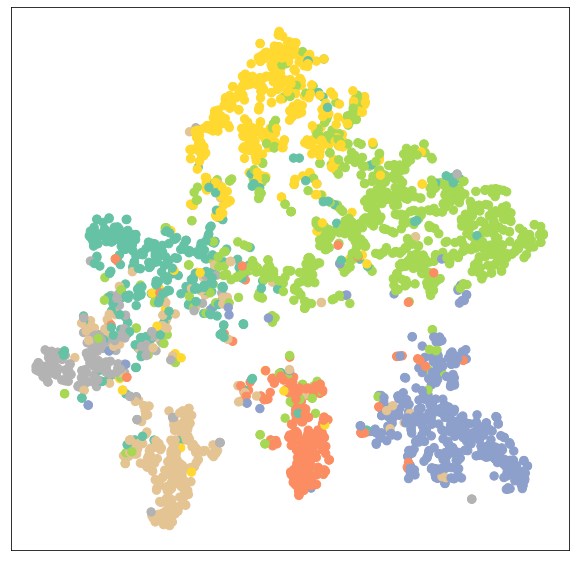

